In [92]:
import requests

url = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.xml?accessType=DOWNLOAD"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Get the content of the response
    data = response.content

    # Save the content to a file
    with open("data.xml", "wb") as file:
        file.write(data)
    print("Data downloaded successfully.")
else:
    print("Failed to download data. Status code:", response.status_code)

Data downloaded successfully.


**note that the data is very big and it might take time to get it**

### import libraries

In [93]:
import numpy as np
import pandas as pd
from lxml import etree
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
import folium
from folium.plugins import FastMarkerCluster
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.diagnostic import het_goldfeldquandt
from tabulate import tabulate


### reading the data

In [94]:
from lxml import etree

# Parse the XML file using lxml
parser = etree.XMLParser(recover=True)
tree = etree.parse("data.xml", parser=parser)
root = tree.getroot()

# Define a function to extract data from XML
def extract_data(element):
    data = {}
    for child in element:
        data[child.tag] = child.text
    return data

# Extract data from each row and store in a list of dictionaries
rows_data = [extract_data(row) for row in root.findall(".//row")]

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(rows_data)


In [95]:
df.head()

,row,crash_date,crash_time,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,...,latitude,longitude,location,cross_street_name,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2021-09-11T00:00:00,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2022-03-26T00:00:00,11:45,QUEENSBORO BRIDGE UPPER,NaN,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2022-06-29T00:00:00,6:55,THROGS NECK BRIDGE,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2021-09-11T00:00:00,9:35,NaN,NaN,0,0,0,0,0,...,40.667202,-73.8665,NaN,1211 LORING AVENUE,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499449 entries, 0 to 499448
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   row                            0 non-null       float64
 1   crash_date                     499448 non-null  object 
 2   crash_time                     499448 non-null  object 
 3   on_street_name                 371213 non-null  object 
 4   off_street_name                238310 non-null  object 
 5   number_of_persons_injured      499446 non-null  object 
 6   number_of_persons_killed       499447 non-null  object 
 7   number_of_pedestrians_injured  499447 non-null  object 
 8   number_of_pedestrians_killed   499447 non-null  object 
 9   number_of_cyclist_injured      499447 non-null  object 
 10  number_of_cyclist_killed       499447 non-null  object 
 11  number_of_motorist_injured     499447 non-null  object 
 12  number_of_motorist_killed     

## **Handling missing values**

### Missing values

* what would be our threshold? 

For unsupervised learning tasks, the choice of threshold for dropping columns with missing values depends on the specific dataset and the nature of the analysis we're performing. Here are a few guidelines:

1. **Low Threshold (e.g., 0.1)**: If your dataset has a large number of columns and you want to be more conservative in dropping columns, you could use a lower threshold, such as 0.1 (10% missing values). This way, you retain more information, but you may need to handle missing values in other ways, such as imputation.

2. **Moderate Threshold (e.g., 0.3 to 0.5)**: A threshold between 0.3 to 0.5 (30% to 50% missing values) is often used as a balance between retaining enough information and dropping columns that may not be informative due to a high number of missing values.

3. **High Threshold (e.g., 0.7 to 0.9)**: If you have a strict requirement for complete data or if columns with many missing values are unlikely to provide meaningful insights, you could use a higher threshold, such as 0.7 to 0.9 (70% to 90% missing values), to drop columns more aggressively.

Ultimately, it is often a good idea to experiment with different thresholds and observe the impact on your results to determine the most suitable threshold for our specific task.

In [97]:
def drop_columns_with_many_missing_values(df, threshold=0.5):
    """
    Drop columns from a DataFrame that have more missing values than the specified threshold.

    Args:
    - df (pd.DataFrame): Input DataFrame.
    - threshold (float): Threshold for the proportion of missing values in a column. Columns
                          with missing values exceeding this threshold will be dropped. Default is 0.5.

    Returns:
    - pd.DataFrame: DataFrame with columns dropped.
    - int: Number of columns left after dropping columns.
    - list: Columns that were dropped.
    """
    missing_values = df.isnull().mean()
    columns_to_drop = missing_values[missing_values > threshold].index.tolist()
    cols_dropped = columns_to_drop.copy()
    df = df.drop(columns=columns_to_drop)
    cols_left = df.shape[1]
    return df, cols_left, cols_dropped

# Example usage
df_cleaned, cols_left, cols_dropped = drop_columns_with_many_missing_values(df, threshold=0.5)
print(f"Number of columns left after dropping columns with more than 50% missing values: {cols_left}")



Number of columns left after dropping columns with more than 50% missing values: 20


In [98]:
print("\nAfter dropping columns:")
df_cleaned.isnull().sum().sort_values()


After dropping columns:


crash_date                            1
crash_time                            1
collision_id                          2
number_of_motorist_killed             2
number_of_cyclist_killed              2
number_of_cyclist_injured             2
number_of_motorist_injured            2
number_of_pedestrians_injured         2
number_of_persons_killed              2
number_of_pedestrians_killed          2
number_of_persons_injured             3
contributing_factor_vehicle_1      2130
vehicle_type_code1                 4579
latitude                          41036
longitude                         41036
contributing_factor_vehicle_2     98007
on_street_name                   128236
vehicle_type_code2               137615
borough                          173785
zip_code                         173857
dtype: int64

check the columns that was dropped out 

In [99]:
print(f"Columns dropped: {cols_dropped}")

Columns dropped: ['row', 'off_street_name', 'location', 'cross_street_name', 'contributing_factor_vehicle_3', 'vehicle_type_code_3', 'contributing_factor_vehicle_4', 'vehicle_type_code_4', 'contributing_factor_vehicle_5', 'vehicle_type_code_5']


off_street_name: We have a column called on_street_name which basically says the same. We assume that the off_street_name was not filled up because of that.

location: We have both columns latitude, longitude, and zip code. The location has many NaNs and therefore it was dropped out.

cross_street_name: Same as off_street_name.

contributing_factor_vehicle_3, vehicle_type_code_3: Occur only in car accidents with 3 or more vehicles.

contributing_factor_vehicle_4, vehicle_type_code_4, contributing_factor_vehicle_5, vehicle_type_code_5: Same as contributing_factor_vehicle_3, etc.

****therefore we would focus on car accidents with only 2 cars involved****

##### Checking rows with missing values

In [100]:
def count_rows_with_empty_values(df, threshold):
    """
    Count the number of rows in a DataFrame that have more empty values (NaN) than the specified threshold.

    Args:
    - df (pd.DataFrame): Input DataFrame.
    - threshold (int): Threshold for the number of empty values in a row. Rows
                        with empty values exceeding this threshold will be counted.

    Returns:
    - int: Number of rows with empty values exceeding the threshold.
    """
    # Count the number of empty values in each row
    num_of_empty_values = df.isnull().sum(axis=1)
    
    # Count the number of rows with empty values exceeding the threshold
    rows_with_empty_values = (num_of_empty_values > threshold).sum()
    
    return rows_with_empty_values


In [101]:
rows_with_empty = count_rows_with_empty_values(df, threshold=10)
print(f"Number of rows with and more than 10 empty values: {rows_with_empty}")

Number of rows with and more than 10 empty values: 248892


In [102]:
def keep_rows_with_few_nans(df, threshold=0.2):
    """
    Keep rows in a DataFrame that have less than the specified percentage of NaN values.

    Args:
    - df (pd.DataFrame): Input DataFrame.
    - threshold (float): Threshold for the percentage of NaN values in a row. Rows
                          with NaN values below this threshold will be kept. Default is 0.2 (20%).

    Returns:
    - pd.DataFrame: DataFrame with rows kept.
    """
    # Calculate the percentage of NaN values in each row
    num_of_nans = df.isnull().sum(axis=1)
    total_values_per_row = df.shape[1]
    perc_nans_per_row = num_of_nans / total_values_per_row * 100
    
    # Keep rows with percentage of NaN values below the threshold
    rows_to_keep = perc_nans_per_row < threshold
    df_filtered = df.loc[rows_to_keep]
    
    return df_filtered



In [103]:
df_filtered = keep_rows_with_few_nans(df_cleaned, threshold=0.2)
print(f"Number of rows with more less than 0.2 percent empty values: {rows_with_empty}")

Number of rows with more less than 0.2 percent empty values: 248892


In [104]:
df_filtered.head()

,crash_date,crash_time,on_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,collision_id,vehicle_type_code1,vehicle_type_code2,borough,zip_code,latitude,longitude
10,2021-12-14T00:00:00,14:58,3 AVENUE,0,0,0,0,0,0,0,0,Passing Too Closely,Unspecified,4486519,Sedan,Station Wagon/Sport Utility Vehicle,MANHATTAN,10017,40.75144,-73.97397
12,2021-12-14T00:00:00,16:50,SPRINGFIELD BOULEVARD,0,0,0,0,0,0,0,0,Turning Improperly,Unspecified,4487127,Sedan,Station Wagon/Sport Utility Vehicle,QUEENS,11413,40.675884,-73.75577
15,2021-12-14T00:00:00,23:10,NORTH CONDUIT AVENUE,2,0,0,0,0,0,2,0,Reaction to Uninvolved Vehicle,Unspecified,4486635,Sedan,Sedan,QUEENS,11434,40.66684,-73.78941
19,2021-12-11T00:00:00,19:43,WEST KINGSBRIDGE ROAD,1,0,0,0,0,0,1,0,Unspecified,Unspecified,4487040,Station Wagon/Sport Utility Vehicle,Sedan,BRONX,10463,40.87262,-73.904686
25,2021-12-13T00:00:00,17:40,VICTORY BOULEVARD,1,0,0,0,0,0,1,0,Unspecified,Unspecified,4487001,Sedan,Sedan,STATEN ISLAND,10301,40.63165,-74.08762


In [105]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143752 entries, 10 to 499446
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   crash_date                     143752 non-null  object
 1   crash_time                     143752 non-null  object
 2   on_street_name                 143752 non-null  object
 3   number_of_persons_injured      143752 non-null  object
 4   number_of_persons_killed       143752 non-null  object
 5   number_of_pedestrians_injured  143752 non-null  object
 6   number_of_pedestrians_killed   143752 non-null  object
 7   number_of_cyclist_injured      143752 non-null  object
 8   number_of_cyclist_killed       143752 non-null  object
 9   number_of_motorist_injured     143752 non-null  object
 10  number_of_motorist_killed      143752 non-null  object
 11  contributing_factor_vehicle_1  143752 non-null  object
 12  contributing_factor_vehicle_2  143752 non-n

#### converting dtypes

In [106]:

# Convert 'number_of_persons_injured', 'number_of_persons_killed', and other columns to int64 dtype
columns_to_convert_to_int = ['number_of_persons_injured', 'number_of_persons_killed', 'number_of_pedestrians_injured',
                              'number_of_pedestrians_killed', 'number_of_cyclist_injured', 'number_of_cyclist_killed',
                              'number_of_motorist_injured', 'number_of_motorist_killed']
df_filtered[columns_to_convert_to_int] = df_filtered[columns_to_convert_to_int].astype('int64')

# Convert 'latitude' and 'longitude' columns to float64 dtype
df_filtered['latitude'] = df_filtered['latitude'].astype('float64')
df_filtered['longitude'] = df_filtered['longitude'].astype('float64')

# Print DataFrame info
df_filtered.info()


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\4273191590.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[columns_to_convert_to_int] = df_filtered[columns_to_convert_to_int].astype('int64')
C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\4273191590.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['latitude'] = df_filtered['latitude'].astype('float64')
C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\4273191590.py:9: SettingWithCopyWarning: 
A value is trying to be set on

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143752 entries, 10 to 499446
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   crash_date                     143752 non-null  object 
 1   crash_time                     143752 non-null  object 
 2   on_street_name                 143752 non-null  object 
 3   number_of_persons_injured      143752 non-null  int64  
 4   number_of_persons_killed       143752 non-null  int64  
 5   number_of_pedestrians_injured  143752 non-null  int64  
 6   number_of_pedestrians_killed   143752 non-null  int64  
 7   number_of_cyclist_injured      143752 non-null  int64  
 8   number_of_cyclist_killed       143752 non-null  int64  
 9   number_of_motorist_injured     143752 non-null  int64  
 10  number_of_motorist_killed      143752 non-null  int64  
 11  contributing_factor_vehicle_1  143752 non-null  object 
 12  contributing_factor_vehicle_2

perform binning method on the crash_time

In [107]:
# Convert 'crash_time' column to datetime format
df_filtered['crash_time'] = pd.to_datetime(df_filtered['crash_time'], format='%H:%M')

# Create a new column for the time category
df_filtered['time_category'] = pd.cut(
    df_filtered['crash_time'].dt.hour,
    bins=[0, 6, 14, 20, 24],
    labels=['night', 'morning', 'noon', 'night'],
    right=False,
    include_lowest=True,
    ordered=False  # Ensure labels are not required to be unique
)

df_filtered.head()


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\222192603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['crash_time'] = pd.to_datetime(df_filtered['crash_time'], format='%H:%M')
C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\222192603.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time_category'] = pd.cut(


,crash_date,crash_time,on_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,...,contributing_factor_vehicle_1,contributing_factor_vehicle_2,collision_id,vehicle_type_code1,vehicle_type_code2,borough,zip_code,latitude,longitude,time_category
10,2021-12-14T00:00:00,1900-01-01 14:58:00,3 AVENUE,0,0,0,0,0,0,0,...,Passing Too Closely,Unspecified,4486519,Sedan,Station Wagon/Sport Utility Vehicle,MANHATTAN,10017,40.751440,-73.973970,noon
12,2021-12-14T00:00:00,1900-01-01 16:50:00,SPRINGFIELD BOULEVARD,0,0,0,0,0,0,0,...,Turning Improperly,Unspecified,4487127,Sedan,Station Wagon/Sport Utility Vehicle,QUEENS,11413,40.675884,-73.755770,noon
15,2021-12-14T00:00:00,1900-01-01 23:10:00,NORTH CONDUIT AVENUE,2,0,0,0,0,0,2,...,Reaction to Uninvolved Vehicle,Unspecified,4486635,Sedan,Sedan,QUEENS,11434,40.666840,-73.789410,night
19,2021-12-11T00:00:00,1900-01-01 19:43:00,WEST KINGSBRIDGE ROAD,1,0,0,0,0,0,1,...,Unspecified,Unspecified,4487040,Station Wagon/Sport Utility Vehicle,Sedan,BRONX,10463,40.872620,-73.904686,noon
25,2021-12-13T00:00:00,1900-01-01 17:40:00,VICTORY BOULEVARD,1,0,0,0,0,0,1,...,Unspecified,Unspecified,4487001,Sedan,Sedan,STATEN ISLAND,10301,40.631650,-74.087620,noon


In [108]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143752 entries, 10 to 499446
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   crash_date                     143752 non-null  object        
 1   crash_time                     143752 non-null  datetime64[ns]
 2   on_street_name                 143752 non-null  object        
 3   number_of_persons_injured      143752 non-null  int64         
 4   number_of_persons_killed       143752 non-null  int64         
 5   number_of_pedestrians_injured  143752 non-null  int64         
 6   number_of_pedestrians_killed   143752 non-null  int64         
 7   number_of_cyclist_injured      143752 non-null  int64         
 8   number_of_cyclist_killed       143752 non-null  int64         
 9   number_of_motorist_injured     143752 non-null  int64         
 10  number_of_motorist_killed      143752 non-null  int64         
 11 

In [109]:
df=df_filtered

we will check the unique_vehicle_types columns

In [110]:
unique_vehicle_types_1 = df['vehicle_type_code1'].unique()
unique_vehicle_types_2 = df['vehicle_type_code2'].unique()
vehicle_types = list(set(unique_vehicle_types_1) | set(unique_vehicle_types_2))
vehicle_types

['Delivery',
 'School Bus',
 'road sweep',
 'police veh',
 'SKID LOADE',
 'Tractor Truck Diesel',
 'FLATBED',
 'tow truck',
 'Minibike',
 'PICKUP',
 'DIRTBIKE',
 'St',
 'Plow  truc',
 'YELLOW BUS',
 'CMIXER',
 'Electric S',
 'Pick up tr',
 'crane',
 'EMBULANCE',
 'Garbage or Refuse',
 'Light trai',
 'Pick Up',
 'Bus',
 'STAKE TRUC',
 'semi-trail',
 'MAILTRUCK',
 'PICKU',
 'SEDAN',
 'Vanette',
 'Lift Boom',
 'F550',
 'Fire',
 'Pickup with mounted Camper',
 'FIRTRUCK',
 'Ambul',
 'E- MOTOR B',
 'conv',
 'Station Wagon/Sport Utility Vehicle',
 'Excavator',
 'BULLDOZER',
 'TRK',
 'OMR',
 'Work van',
 'tract',
 'USPS MAIL',
 'us postal',
 'COM',
 'posta',
 'FDNY Fire',
 'E-BIK',
 'SEGWA',
 'CARGO VAN',
 'JOHN',
 'Dump',
 'FORD AMBUL',
 'trailer',
 'TRUCK VAN',
 'TRACT',
 'toolcat',
 'BROWN',
 'FDNY',
 'food truck',
 'REVEL MOPE',
 'Dirt bike',
 'TRAIL',
 'CONTRUCTIO',
 'FLAT BED',
 '4 dr sedan',
 'Taxi',
 'Car traile',
 'JOHND',
 'DOT EQUIPM',
 'Mop Pad',
 'DUMP',
 'Motorscoot',
 'G COM',
 

we can see that the column is too one-to-one function and we will drop it for now

##### we would want to keep only the rows that has more information than only the location and the contribue factores, therefore we will drop the rows that do not consist any injured or killed people.

In [111]:
# List of numerical columns
numerical_features = [
    'number_of_persons_injured', 'number_of_persons_killed',
    'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
    'number_of_cyclist_injured', 'number_of_cyclist_killed',
    'number_of_motorist_injured', 'number_of_motorist_killed'
]

# Convert the numerical columns to numeric format
df[numerical_features] = df[numerical_features].apply(pd.to_numeric, errors='coerce')

# Count the number of times each column has a value greater than 0
counts = (df[numerical_features] > 0).sum()

# Display the counts
for feature, count in counts.items():
    print(f"Number of times {feature} has a value greater than 0: {count}")


Number of times number_of_persons_injured has a value greater than 0: 44090
Number of times number_of_persons_killed has a value greater than 0: 202
Number of times number_of_pedestrians_injured has a value greater than 0: 368
Number of times number_of_pedestrians_killed has a value greater than 0: 24
Number of times number_of_cyclist_injured has a value greater than 0: 8277
Number of times number_of_cyclist_killed has a value greater than 0: 47
Number of times number_of_motorist_injured has a value greater than 0: 34092
Number of times number_of_motorist_killed has a value greater than 0: 120


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\2816664941.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_features] = df[numerical_features].apply(pd.to_numeric, errors='coerce')


In [112]:
# Define the columns to check
cols_to_check = [
    'number_of_persons_injured', 'number_of_persons_killed',
    'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
    'number_of_cyclist_injured', 'number_of_cyclist_killed',
    'number_of_motorist_injured', 'number_of_motorist_killed'
]

# Filter the DataFrame to keep rows where at least one of the specified columns has a value greater than 0
df = df[df[cols_to_check].gt(0).any(axis=1)]


##### dropping the rows with broken location

In [113]:
df = df[df['longitude'] != 0.000000]


##### we will check the contributing_factor_vehicle columns

In [114]:
contributing_factor_vehicle_1 = df['contributing_factor_vehicle_1'].unique()
contributing_factor_vehicle_2 = df['contributing_factor_vehicle_2'].unique()
contributing_factor_vehicle = list(set(contributing_factor_vehicle_1) | set(contributing_factor_vehicle_2))
contributing_factor_vehicle

['Driver Inexperience',
 'Tire Failure/Inadequate',
 'Shoulders Defective/Improper',
 'Backing Unsafely',
 'Traffic Control Device Improper/Non-Working',
 'Fell Asleep',
 'Outside Car Distraction',
 'Traffic Control Disregarded',
 'Cell Phone (hand-Held)',
 'Passing Too Closely',
 'Using On Board Navigation Device',
 'Passing or Lane Usage Improper',
 'Pavement Defective',
 'Glare',
 'Unsafe Speed',
 'Accelerator Defective',
 'Alcohol Involvement',
 'Eating or Drinking',
 'Other Vehicular',
 'Tinted Windows',
 'Pavement Slippery',
 'Oversized Vehicle',
 'Following Too Closely',
 'Other Electronic Device',
 'Obstruction/Debris',
 'Drugs (illegal)',
 'Lost Consciousness',
 'Failure to Keep Right',
 'Unsafe Lane Changing',
 'Failure to Yield Right-of-Way',
 'Physical Disability',
 'Fatigued/Drowsy',
 'Driver Inattention/Distraction',
 'Driverless/Runaway Vehicle',
 'Prescription Medication',
 'Brakes Defective',
 'Lane Marking Improper/Inadequate',
 'View Obstructed/Limited',
 'Passenger 

we would leave it as it is since the information is crucial and quite orgenized.

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43877 entries, 15 to 499370
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   crash_date                     43877 non-null  object        
 1   crash_time                     43877 non-null  datetime64[ns]
 2   on_street_name                 43877 non-null  object        
 3   number_of_persons_injured      43877 non-null  int64         
 4   number_of_persons_killed       43877 non-null  int64         
 5   number_of_pedestrians_injured  43877 non-null  int64         
 6   number_of_pedestrians_killed   43877 non-null  int64         
 7   number_of_cyclist_injured      43877 non-null  int64         
 8   number_of_cyclist_killed       43877 non-null  int64         
 9   number_of_motorist_injured     43877 non-null  int64         
 10  number_of_motorist_killed      43877 non-null  int64         
 11  contributing_

## **EDA**

##### Get basic statistics for numerical features


In [116]:
numerical_features = ['number_of_persons_injured', 'number_of_persons_killed', 'number_of_pedestrians_injured',
                              'number_of_pedestrians_killed', 'number_of_cyclist_injured', 'number_of_cyclist_killed',
                              'number_of_motorist_injured', 'number_of_motorist_killed']
stats = df[numerical_features].describe()
print("Descriptive statistics:")
print(stats.to_string())

Descriptive statistics:
       number_of_persons_injured  number_of_persons_killed  number_of_pedestrians_injured  number_of_pedestrians_killed  number_of_cyclist_injured  number_of_cyclist_killed  number_of_motorist_injured  number_of_motorist_killed
count               43877.000000              43877.000000                   43877.000000                   43877.00000               43877.000000              43877.000000                43877.000000               43877.000000
mean                    1.427308                  0.004786                       0.009572                       0.00057                   0.190282                  0.001071                    1.189598                   0.002872
std                     0.881059                  0.072244                       0.111755                       0.02480                   0.400461                  0.032712                    1.061876                   0.056817
min                     0.000000                  0.000000      

In [117]:
stats = df[numerical_features].max()
stats

number_of_persons_injured        18
number_of_persons_killed          3
number_of_pedestrians_injured     5
number_of_pedestrians_killed      2
number_of_cyclist_injured         3
number_of_cyclist_killed          1
number_of_motorist_injured       18
number_of_motorist_killed         3
dtype: int64

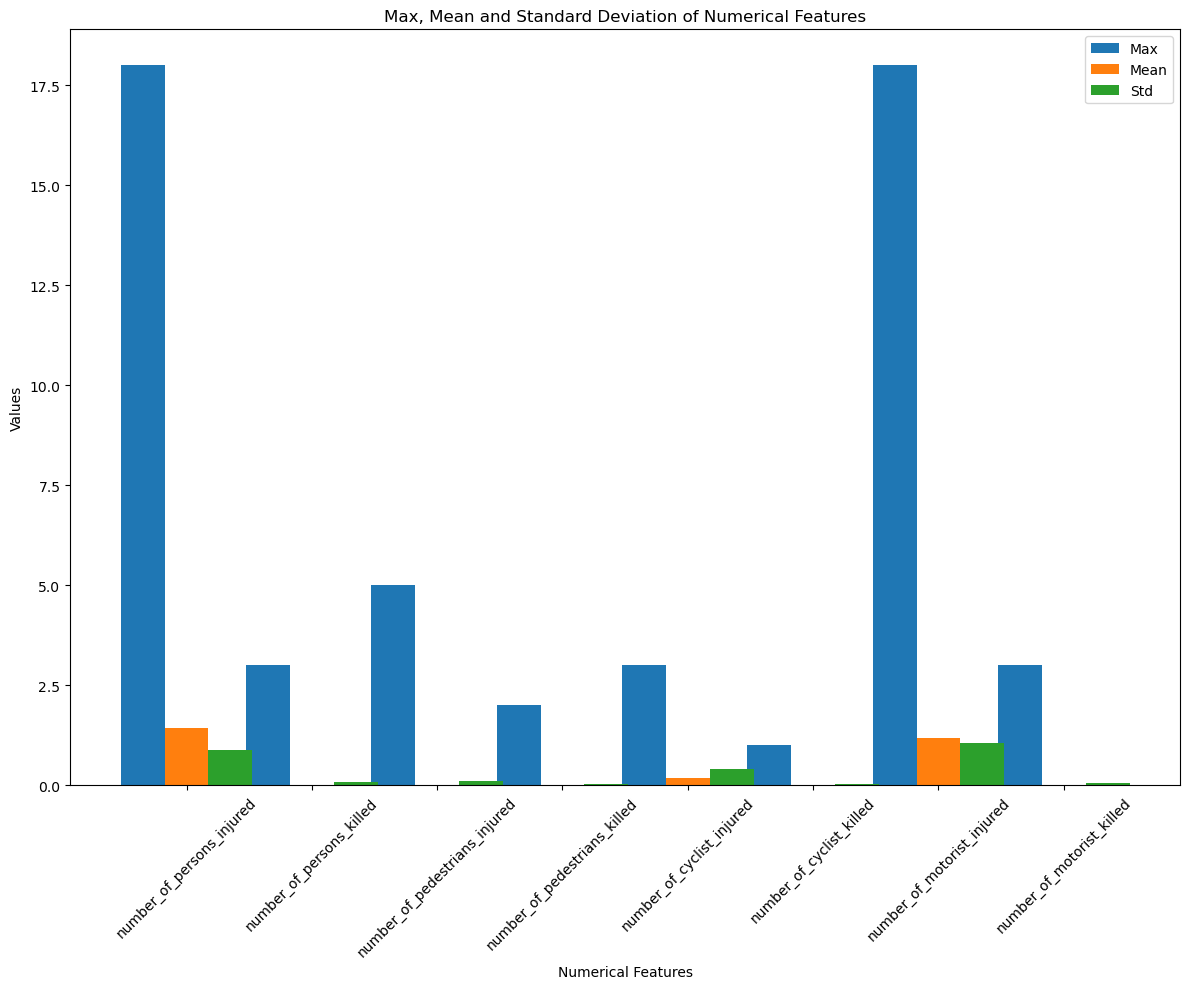

In [118]:
# Calculate descriptive statistics for numerical features
numerical_features = ['number_of_persons_injured', 'number_of_persons_killed', 'number_of_pedestrians_injured',
                      'number_of_pedestrians_killed', 'number_of_cyclist_injured', 'number_of_cyclist_killed',
                      'number_of_motorist_injured', 'number_of_motorist_killed']

# Extract max, mean and standard deviation values
max_values = df[numerical_features].max()
mean_values = df[numerical_features].mean()
std_values = df[numerical_features].std()

# Create a bar graph to visualize max, mean and standard deviation values
index = range(len(numerical_features))
bar_width = 0.35

plt.figure(figsize=(12, 10))
plt.bar(index, max_values, bar_width, label='Max')
plt.bar([p + bar_width for p in index], mean_values, bar_width, label='Mean')
plt.bar([p + 2*bar_width for p in index], std_values, bar_width, label='Std')
plt.xlabel('Numerical Features')
plt.ylabel('Values')
plt.title('Max, Mean and Standard Deviation of Numerical Features')
plt.xticks([p + bar_width for p in index], numerical_features, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

##### we will check the mose 'contributing' factor

In [119]:
df['contributing_factor_vehicle_1'].unique()
# Assuming 'column_name' is the name of the column you want to check
unique_counts = df['contributing_factor_vehicle_1'].value_counts()
unique_counts


Driver Inattention/Distraction                           12162
Unspecified                                               7820
Failure to Yield Right-of-Way                             5791
Traffic Control Disregarded                               3307
Following Too Closely                                     2958
Unsafe Speed                                              1533
Passing or Lane Usage Improper                            1389
Other Vehicular                                           1157
Turning Improperly                                        1138
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion      786
Driver Inexperience                                        720
Alcohol Involvement                                        710
Unsafe Lane Changing                                       608
View Obstructed/Limited                                    505
Passing Too Closely                                        449
Backing Unsafely                                       

In [120]:
# Assuming df is your DataFrame
grouped_sum = df.iloc[:, :-3].groupby('contributing_factor_vehicle_2').agg('sum')
# Filter out the row with "Unspecified" using boolean indexing
filtered_grouped_sum = grouped_sum[grouped_sum.index != 'Unspecified']

filtered_grouped_sum

C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\3725831006.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_sum = df.iloc[:, :-3].groupby('contributing_factor_vehicle_2').agg('sum')


,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed
contributing_factor_vehicle_2,,,,,,,,
Aggressive Driving/Road Rage,59,0,1,0,4,0,54,0
Alcohol Involvement,80,0,0,0,12,0,66,0
Backing Unsafely,58,0,0,0,2,0,56,0
Brakes Defective,12,0,0,0,2,0,10,0
Cell Phone (hand-Held),3,0,0,0,0,0,3,0
Driver Inattention/Distraction,5406,2,20,0,917,0,4265,2
Driver Inexperience,293,1,0,0,41,0,242,1
Driverless/Runaway Vehicle,3,0,0,0,1,0,2,0
Failure to Keep Right,27,0,0,0,9,0,18,0


#### *we can see the top 10 contribute factors to the accident*

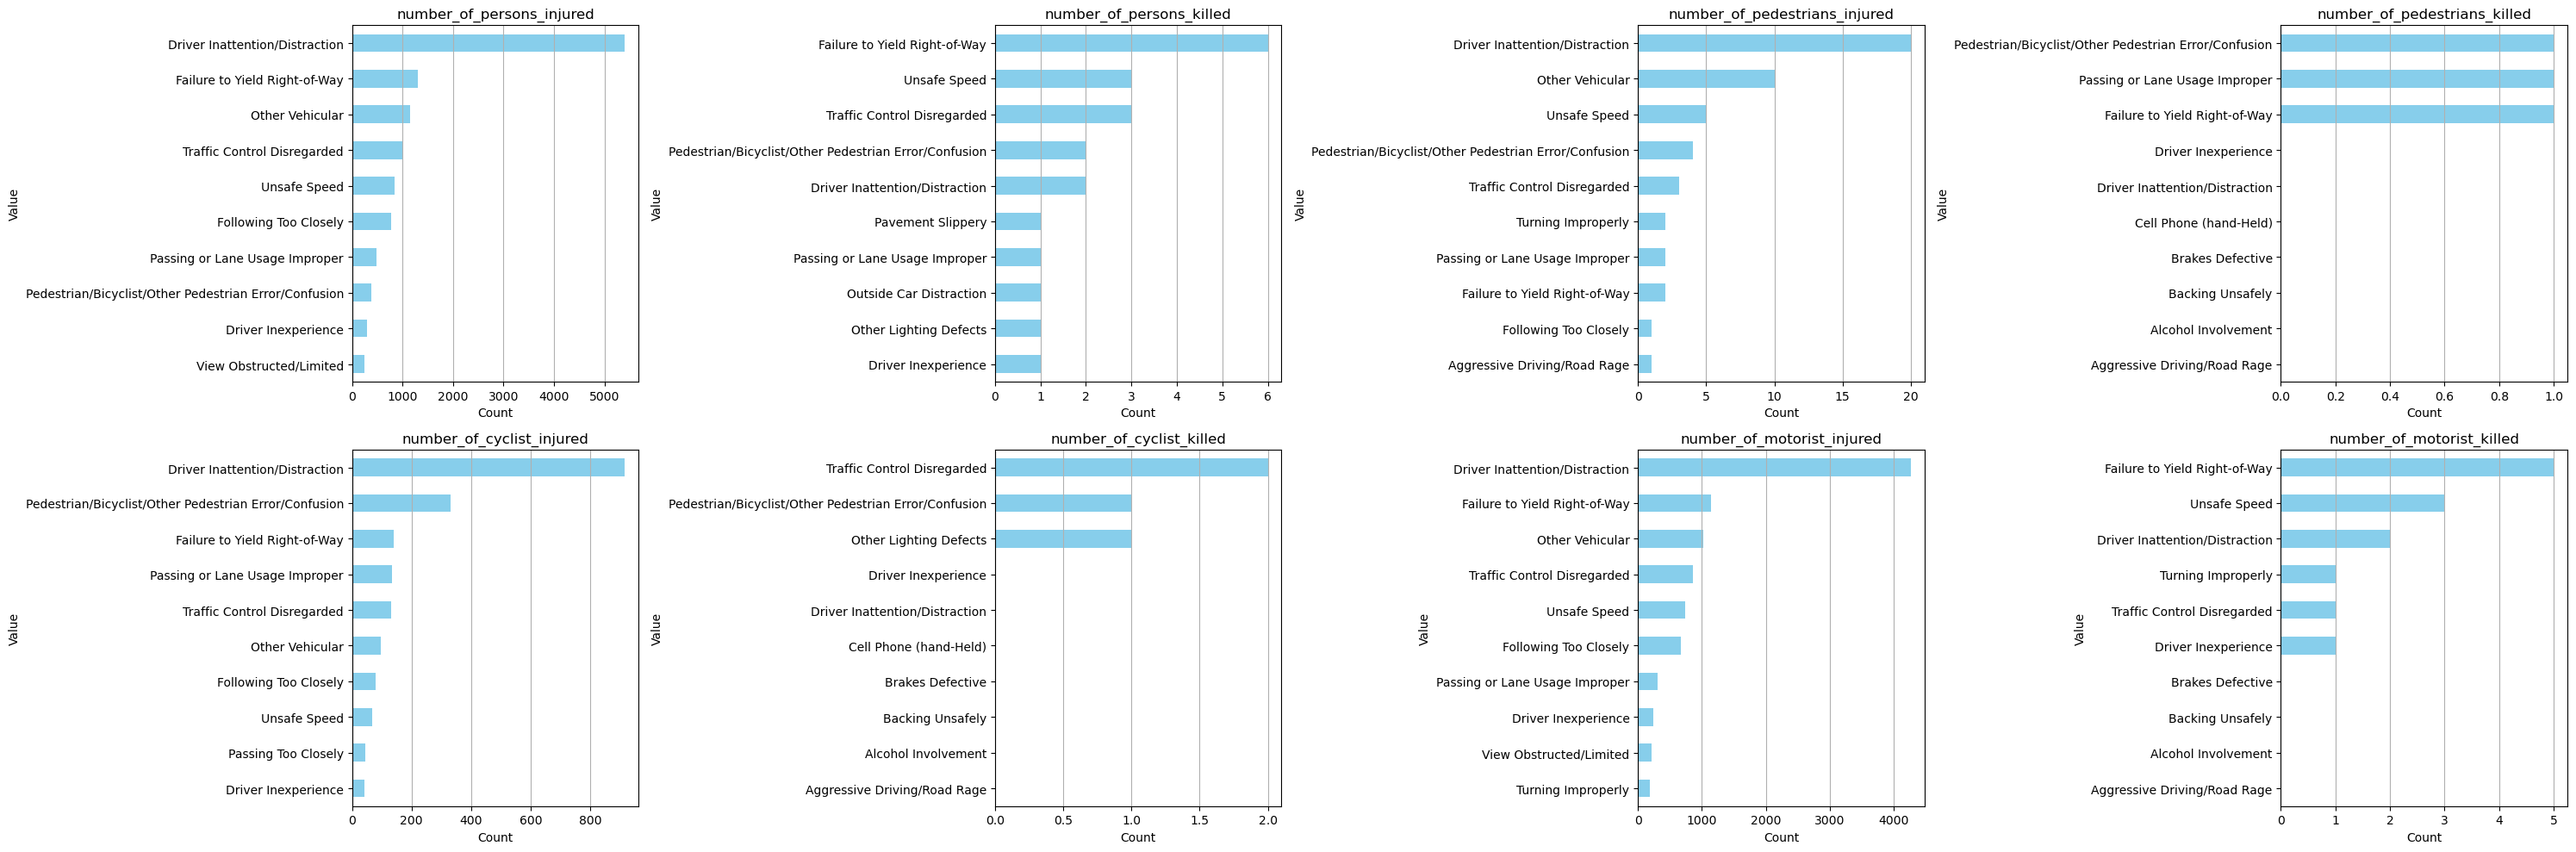

In [121]:
num_cols = len(filtered_grouped_sum.columns[:])  # Exclude the last three columns
cols_per_row = 4  # Number of columns to display per row
num_rows = math.ceil(num_cols / cols_per_row)

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(30, 5*num_rows))

for i, col in enumerate(filtered_grouped_sum.columns[:]):  # Exclude the last three columns
    ax = axes[i // cols_per_row, i % cols_per_row]
    top_values = filtered_grouped_sum[col].nlargest(10)
    top_values.sort_values().plot(kind='barh', color='skyblue', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Count')
    ax.set_ylabel('Value')
    ax.tick_params(axis='y', rotation=0)
    ax.grid(axis='x')
    fig.tight_layout()

plt.show()

***we can see that most of the times, in the top 3 we can find Driver Inattention/Distraction as a significant contributer.***

In [122]:
summary = df.describe()

**We will display the locations (longtitude and latitude) to get some ideas of what we are looking at:**

In [123]:
# Create a new column 'latitude_and_longitude' with tuples
df['latitude_and_longitude'] = list(zip(df['latitude'], df['longitude']))

# Count the occurrences of unique tuples in the new column
df2 = df['latitude_and_longitude'].value_counts()

print(df2)

(40.861862, -73.91282)     59
(40.65616, -73.76736)      52
(40.675735, -73.89686)     42
(40.669476, -73.919975)    34
(40.67816, -73.897484)     33
                           ..
(40.685837, -73.82686)      1
(40.61617, -74.02216)       1
(40.617443, -74.028404)     1
(40.64981, -73.93503)       1
(40.587307, -73.93938)      1
Name: latitude_and_longitude, Length: 18349, dtype: int64


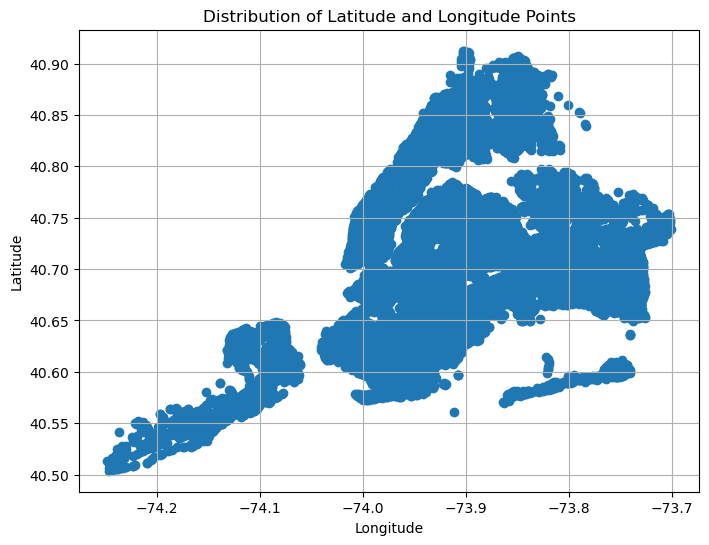

In [124]:
# Extract latitudes and longitudes from the Series index
lats = [lat for lat, _ in df2.index.tolist()]
lons = [lon for _, lon in df2.index.tolist()]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(lons, lats)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of Latitude and Longitude Points')

plt.grid(True)
plt.show()

In [125]:
# Create a map centered at a specific location
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)

# Add FastMarkerCluster for all points
FastMarkerCluster(data=list(zip(df['latitude'], df['longitude']))).add_to(m)

# Display the map
m

We can see that most accidents happen in downtown New York City and Brooklyn, Unlike the other areas.                                                                         
Zooming in to New York City:
And within the city of New York you can see that most of the accidents occur between the midtown and the Upper side.
Therefore, as a recommendation to the City of New York, we would recommend placing police stations at the more dangerous intersections (after examining the map) in this part of New York. Because we already know that the main cause of traffic accidents is Driver Inattention/Distraction. That's why I would consider placing more policemen on the spot, or blue-red lighting which will make the driver more focused.

**Number of injured and killed by date (intervals of 3 months)**

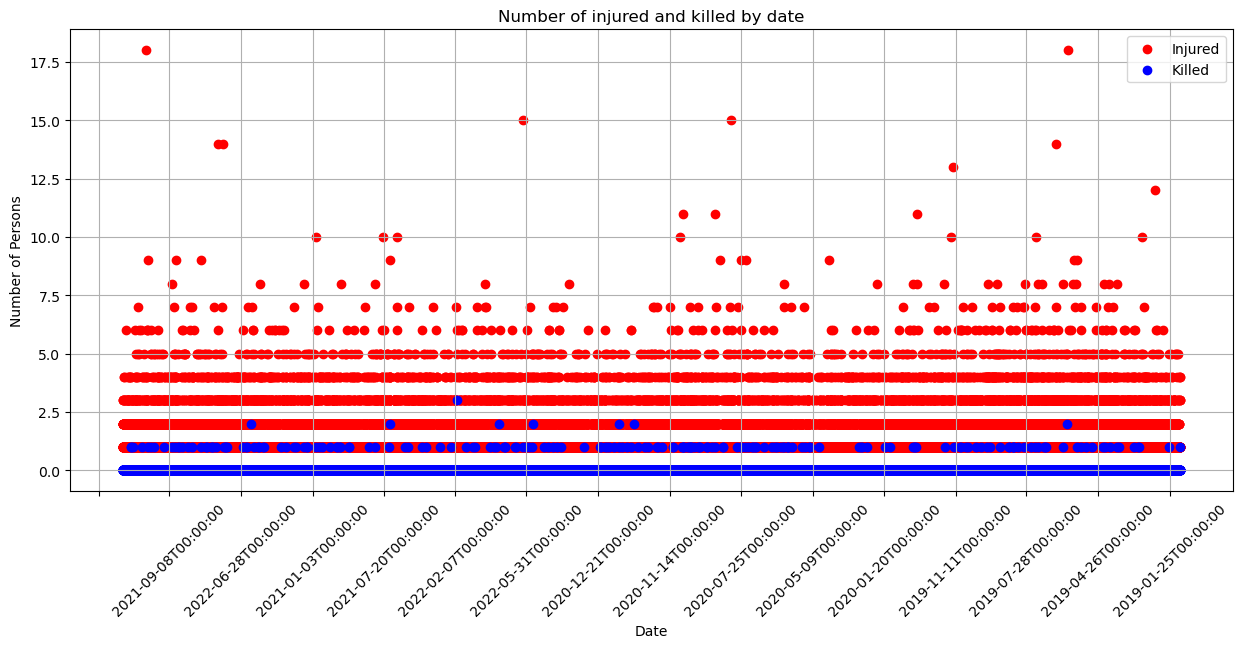

In [131]:

_df = df

# Set the interval for x-axis ticks to 3 months
# date_range = pd.date_range(start=_df['crash_date'].min(), end=_df['crash_date'].max(), freq='30D')

# Plotting the scatter plot with intervals of 3 months
plt.figure(figsize=(15, 6))
plt.scatter(_df['crash_date'], _df['number_of_persons_injured'], color='red', marker='o', label='Injured')
plt.scatter(_df['crash_date'], _df['number_of_persons_killed'], color='blue', marker='o', label='Killed')
plt.xlabel('Date')
plt.ylabel('Number of Persons')
plt.title('Number of injured and killed by date')
plt.legend()


plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%YYYY-%mm-%dd'))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

we can see that from year 2023 there are more accidents with high numbers of people effected than the privious years 

## **Anomaly and Outlier detection**

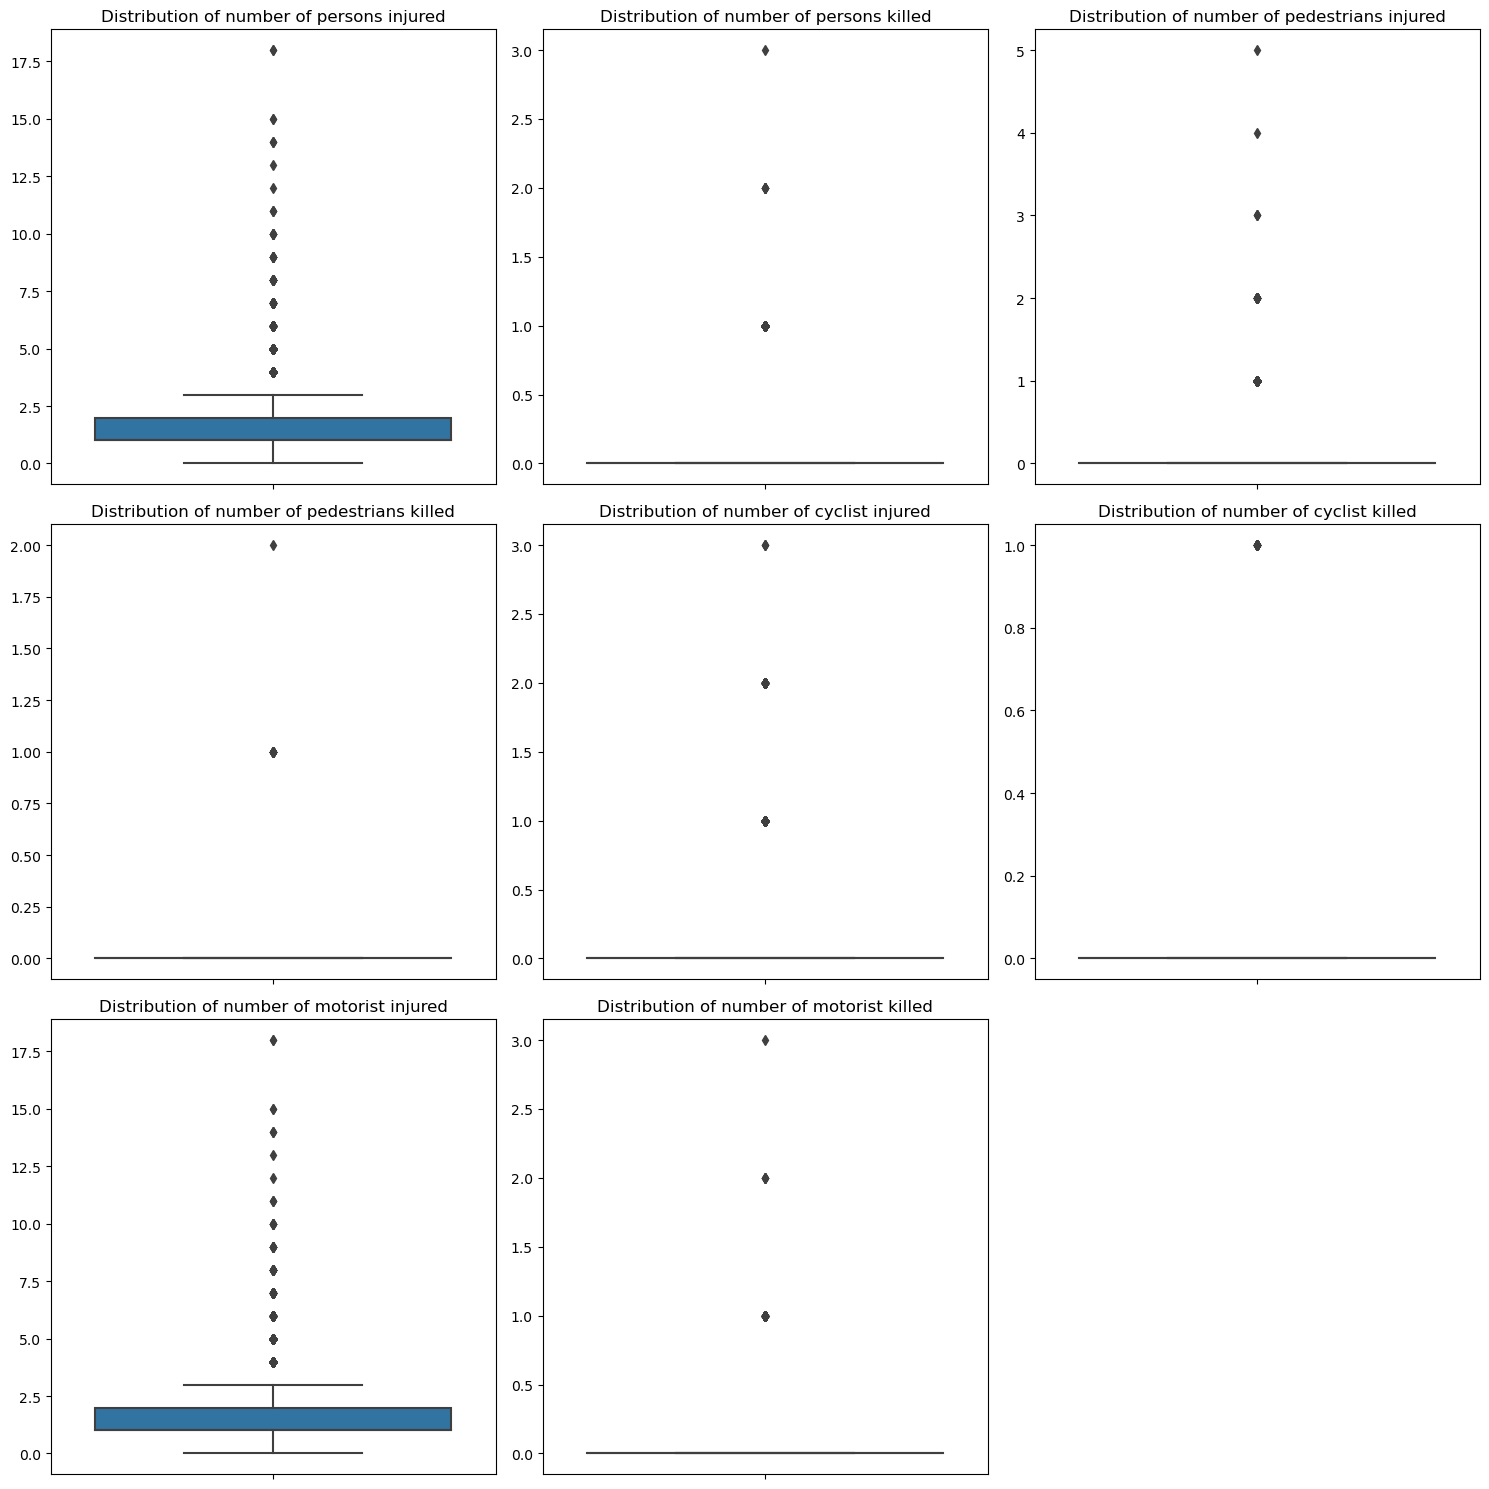

In [132]:
# List of numerical columns
numerical_features = [
    'number_of_persons_injured', 'number_of_persons_killed',
    'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
    'number_of_cyclist_injured', 'number_of_cyclist_killed',
    'number_of_motorist_injured', 'number_of_motorist_killed'
]

# Calculate the number of rows and columns for the grid
num_plots = len(numerical_features)
cols = 3  # Number of columns
rows = math.ceil(num_plots / cols)  # Calculate number of rows

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Flatten the axes array to easily access each subplot
axes = axes.flatten()

# Create boxplots for each numerical feature
for i, feature in enumerate(numerical_features):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature.replace('_', ' ')}")
    axes[i].set_xlabel("")  # Remove x-axis label
    axes[i].set_ylabel("")  # Remove y-axis label

# Remove any unused subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


we wanted to check wether we have outliers or not, we can see that even the most distanced frm the center point are nor too far and would make sense to just leave it as it is.

### Encoding the categorical data

In [133]:

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform both contributing_factor_vehicle_1 and contributing_factor_vehicle_2 columns
encoded = encoder.fit_transform(df[['contributing_factor_vehicle_1', 'contributing_factor_vehicle_2','borough','time_category']])
# Create a DataFrame from the encoded data with column names
df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['contributing_factor_vehicle_1', 'contributing_factor_vehicle_2','borough','time_category']))

# Reset index of the original DataFrame
df_reset = df.reset_index(drop=True)

# Concatenate the original DataFrame with the encoded DataFrame
df_concatenated = pd.concat([df_reset, df_encoded], axis=1)
# Drop the original columns from the concatenated DataFrame
df_concatenated_dropped = df_concatenated.drop(['contributing_factor_vehicle_1', 'contributing_factor_vehicle_2','borough'], axis=1)

df_concatenated_dropped


c:\Users\Selau\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,crash_date,crash_time,on_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,...,contributing_factor_vehicle_2_Vehicle Vandalism,contributing_factor_vehicle_2_View Obstructed/Limited,borough_BRONX,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,time_category_morning,time_category_night,time_category_noon
0,2021-12-14T00:00:00,1900-01-01 23:10:00,NORTH CONDUIT AVENUE,2,0,0,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,2021-12-11T00:00:00,1900-01-01 19:43:00,WEST KINGSBRIDGE ROAD,1,0,0,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2021-12-13T00:00:00,1900-01-01 17:40:00,VICTORY BOULEVARD,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2021-12-14T00:00:00,1900-01-01 12:54:00,FULTON STREET,1,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2021-12-14T00:00:00,1900-01-01 17:15:00,GRAND STREET,1,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43872,2019-01-14T00:00:00,1900-01-01 15:20:00,1 AVENUE,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
43873,2019-02-02T00:00:00,1900-01-01 12:00:00,COLLEGE POINT BOULEVARD,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
43874,2019-01-15T00:00:00,1900-01-01 14:47:00,248 STREET,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
43875,2019-01-27T00:00:00,1900-01-01 14:50:00,167 STREET,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## **Dimensionality Reduction**

we would want to check some of the assumption for using PCA

Heteroscedasticity, refers to the situation where the variance of the errors or residuals in a regression model is not constant across all levels of the independent variables. In simpler terms, it means that the spread of the residuals changes as the value of the independent variable changes.

In [134]:
# List of numerical columns
numerical_features = [
    'number_of_persons_injured', 'number_of_persons_killed',
    'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
    'number_of_cyclist_injured', 'number_of_cyclist_killed',
    'number_of_motorist_injured', 'number_of_motorist_killed'
]

results = []
for i, col1 in enumerate(numerical_features):
    for col2 in numerical_features[i + 1:]:
        _, p_value, _ = het_goldfeldquandt(df[[col1]].values, df[[col2]].values)
        if p_value < 0.05:
            results.append([col1, col2, 'V'])
        else:
            results.append([col1, col2, 'X'])

print(tabulate(results, headers=['Column 1', 'Column 2', 'Homoscedasticity'], tablefmt='pretty'))


+-------------------------------+-------------------------------+------------------+
|           Column 1            |           Column 2            | Homoscedasticity |
+-------------------------------+-------------------------------+------------------+
|   number_of_persons_injured   |   number_of_persons_killed    |        V         |
|   number_of_persons_injured   | number_of_pedestrians_injured |        V         |
|   number_of_persons_injured   | number_of_pedestrians_killed  |        V         |
|   number_of_persons_injured   |   number_of_cyclist_injured   |        V         |
|   number_of_persons_injured   |   number_of_cyclist_killed    |        V         |
|   number_of_persons_injured   |  number_of_motorist_injured   |        X         |
|   number_of_persons_injured   |   number_of_motorist_killed   |        V         |
|   number_of_persons_killed    | number_of_pedestrians_injured |        X         |
|   number_of_persons_killed    | number_of_pedestrians_killed  |

only few of the relation between some of the columns apply for PCA. 
we might go with PCA due to other constraints

C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\469551963.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


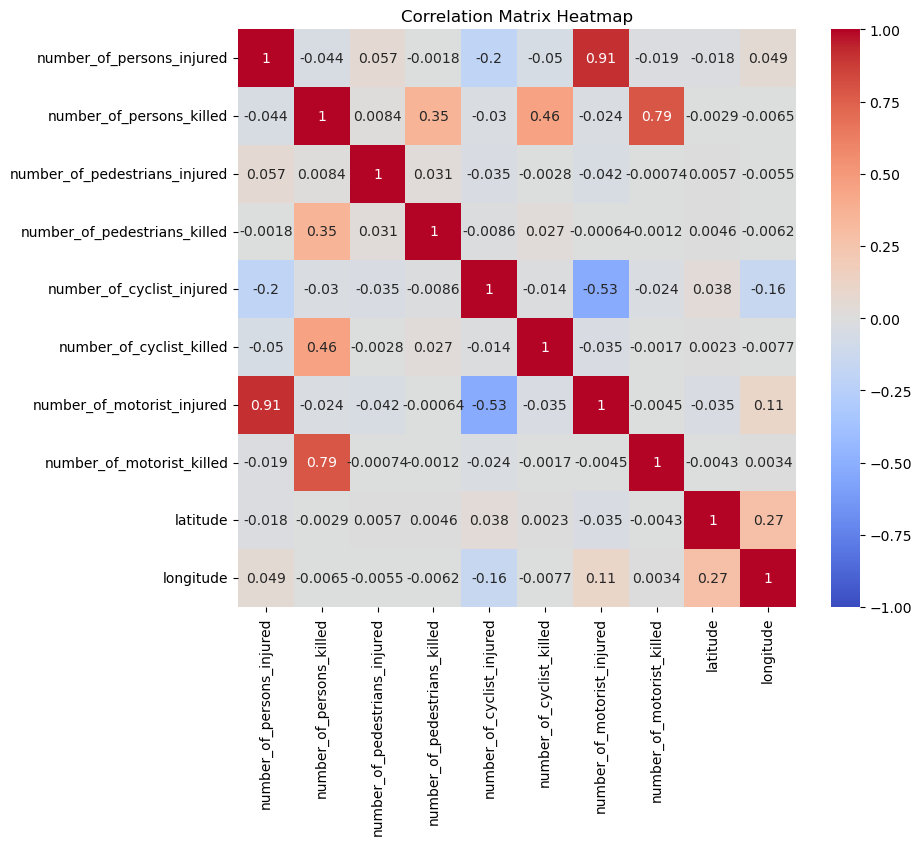

In [135]:
# Correlation analysis
correlation_matrix = df.corr()

plt.figure(figsize=(9, 7.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

we dont find any significant correlation except the correlation between the total amout of injued and killed people to the ones of the motorist.
it emphasize the danger of be motorist.

In [136]:
df = df_concatenated_dropped

In [137]:
df_concatenated_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43877 entries, 0 to 43876
Columns: 125 entries, crash_date to time_category_noon
dtypes: category(1), datetime64[ns](1), float64(108), int64(8), object(7)
memory usage: 41.6+ MB


In [138]:
df_concatenated_dropped.head()


,crash_date,crash_time,on_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,...,contributing_factor_vehicle_2_Vehicle Vandalism,contributing_factor_vehicle_2_View Obstructed/Limited,borough_BRONX,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,time_category_morning,time_category_night,time_category_noon
0,2021-12-14T00:00:00,1900-01-01 23:10:00,NORTH CONDUIT AVENUE,2,0,0,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,2021-12-11T00:00:00,1900-01-01 19:43:00,WEST KINGSBRIDGE ROAD,1,0,0,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2021-12-13T00:00:00,1900-01-01 17:40:00,VICTORY BOULEVARD,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2021-12-14T00:00:00,1900-01-01 12:54:00,FULTON STREET,1,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2021-12-14T00:00:00,1900-01-01 17:15:00,GRAND STREET,1,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


##### we would remove the non numerical cols for the PCA

In [139]:
# Select columns that are not of object type
df = df.select_dtypes(exclude=['object','datetime64','category'])


In [140]:
df.head()

,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,latitude,longitude,...,contributing_factor_vehicle_2_Vehicle Vandalism,contributing_factor_vehicle_2_View Obstructed/Limited,borough_BRONX,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,time_category_morning,time_category_night,time_category_noon
0,2,0,0,0,0,0,2,0,40.666840,-73.789410,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,0,0,0,0,0,1,0,40.872620,-73.904686,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0,0,0,0,1,0,40.631650,-74.087620,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0,0,0,1,0,0,0,40.687534,-73.977500,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,0,0,0,0,0,1,0,40.710957,-73.951126,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43877 entries, 0 to 43876
Columns: 116 entries, number_of_persons_injured to time_category_noon
dtypes: float64(108), int64(8)
memory usage: 38.8 MB


##### we will perform PCA and Scaling:

Number of components: 1, Explained variance sum: 0.021815639660774995
Number of components: 2, Explained variance sum: 0.042981525152391495
Number of components: 3, Explained variance sum: 0.06135707303162581
Number of components: 4, Explained variance sum: 0.07871556405834859
Number of components: 5, Explained variance sum: 0.09453167512611986
Number of components: 6, Explained variance sum: 0.109943729916551
Number of components: 7, Explained variance sum: 0.12354312436462782


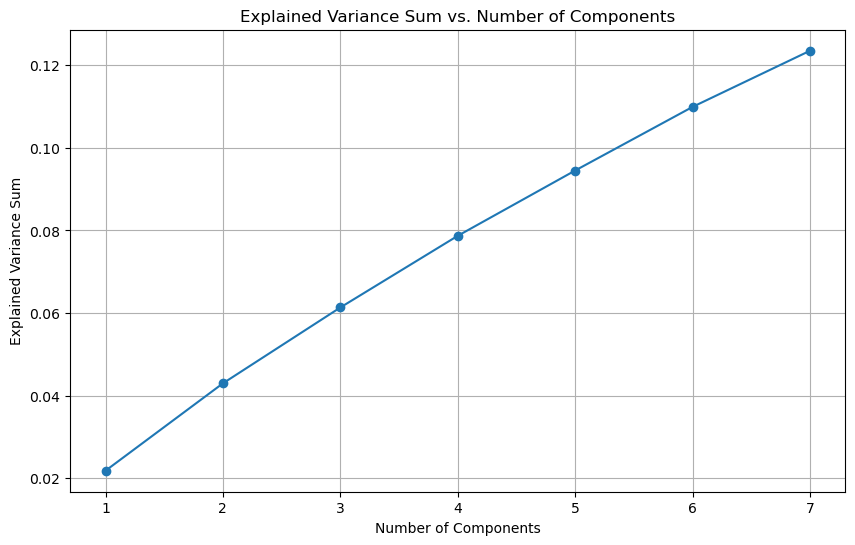

In [142]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on your DataFrame
X_scaled = scaler.fit_transform(df)

# Initialize PCA with 7 components
pca = PCA(n_components=7, random_state=42)

# Perform PCA on the scaled data
X_pca = pca.fit_transform(X_scaled)

# Print the sum of explained variance ratio for each number of components
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_sum = [explained_variance_ratio[0:i].sum() for i in range(1, len(explained_variance_ratio) + 1)]
for n_components, explained_variance in enumerate(explained_variance_sum, start=1):
    print(f"Number of components: {n_components}, Explained variance sum: {explained_variance}")

# Plotting the line plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 8), explained_variance_sum, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Sum')
plt.title('Explained Variance Sum vs. Number of Components')
plt.grid(True)
plt.show()


**the explain varience of 7 components (dimentions) will be good to continue with further more.**

## **Clustering**

#### for K-means we will check the optimal number of clusters using the elbow method, the Silhouette and the SSE.

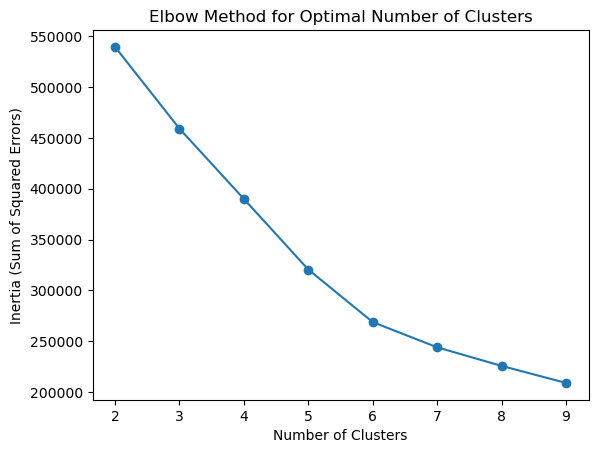

,Clusters,SSE,Silhouette,Sample Count,Min Count,Max Count
0,2,539650.789574,0.208286,1 22041 0 21836 dtype: int64,21836,22041
1,3,459150.557254,0.215330,0 21996 1 21691 2 190 dtype: int64,190,21996
2,4,389971.248471,0.262566,2 16969 1 13426 0 13292 3 190 dt...,190,16969
3,5,320447.379199,0.240582,1 17606 2 17270 0 8774 4 189 3 ...,38,17606
4,6,268711.098734,0.286242,0 14303 2 11477 1 9925 3 7945 5 ...,38,14303
5,7,243879.488518,0.288961,0 13072 1 10891 5 9305 3 7259 2 ...,38,13072
6,8,225594.909984,0.285712,1 12682 0 10700 6 6464 5 6107 2 ...,38,12682
7,9,208816.041365,0.295645,0 12539 2 10643 1 5472 3 5087 8 ...,38,12539


In [143]:
def cluster_and_evaluate(data, cluster_range=[2, 3, 4, 5, 6, 7, 8, 9]):
    
    results_df = pd.DataFrame(columns=['Clusters', 'SSE', 'Silhouette', 'Sample Count', 'Min Count', 'Max Count'])
    elbow_df = pd.DataFrame(columns=['Clusters', 'Inertia'])

    for num_clusters in cluster_range:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        kmeans.fit(data)
        labels = kmeans.labels_
        sample_count = pd.Series(labels).value_counts()

        # Calculate SSE (Sum of Squared Errors)
        sse = kmeans.inertia_
        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, labels)
        
        results_df = pd.concat([results_df, pd.DataFrame({'Clusters': [num_clusters], 'SSE': [sse], 'Silhouette': [silhouette_avg], 'Sample Count': [sample_count], 'Min Count': [sample_count.min()], 'Max Count': [sample_count.max()]})], ignore_index=True)
        elbow_df = pd.concat([elbow_df, pd.DataFrame({'Clusters': [num_clusters], 'Inertia': [sse]})], ignore_index=True)

    # Plotting the Elbow Method
    plt.plot(elbow_df['Clusters'], elbow_df['Inertia'], marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia (Sum of Squared Errors)')
    plt.show()

    return results_df

results = cluster_and_evaluate(X_pca)
results

**we can assume that according to the SSE and the Silhouette score, it would be reccomended to go with 7 clusters.**

##### assuring that it is the right number of clusters, we would check with Adjusted Inertia for each K and alpha_k

##### <blockquote>https://towardsdatascience.com/an-approach-for-choosing-number-of-clusters-for-k-means-c28e614ecb2c</blockquote>

c:\Users\Selau\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Selau\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Selau\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Selau\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Best k for alpha_k=0.02: 9
Best k for alpha_k=0.03: 7
Best k for alpha_k=0.04: 6
Best k for alpha_k=0.05: 6


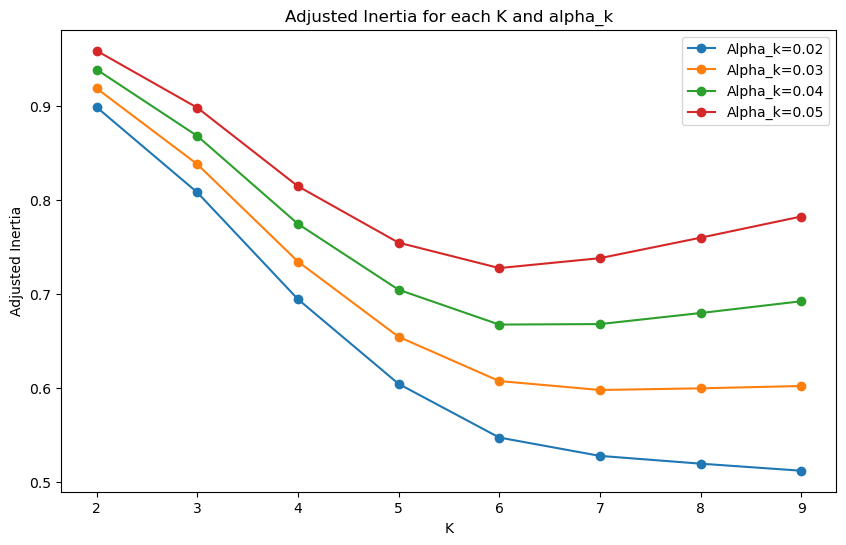

In [144]:
def kMeansRes(scaled_data, k, alpha_k):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeans(scaled_data, k_range, alpha_k_values):
    results_list = []
    for alpha_k in alpha_k_values:
        ans = []
        for k in k_range:
            scaled_inertia = kMeansRes(scaled_data, k, alpha_k)
            ans.append((k, scaled_inertia))
        results = pd.DataFrame(ans, columns=['k', f'Alpha_k={alpha_k}']).set_index('k')
        results_list.append(results)

    best_ks = [results.idxmin()[0] for results in results_list]
    return best_ks, results_list

# Parameters
scaled_data = np.asarray(X_pca).astype(float)
k_range = range(2, 10)
alpha_k_values = [0.02, 0.03, 0.04, 0.05]

# Compute adjusted inertia for each alpha_k value
best_ks, results_list = chooseBestKforKMeans(scaled_data, k_range, alpha_k_values)

# Print best k for each alpha_k value
for alpha_k, best_k in zip(alpha_k_values, best_ks):
    print(f"Best k for alpha_k={alpha_k}: {best_k}")

# Plot the results
plt.figure(figsize=(10, 6))
for i, results in enumerate(results_list):
    plt.plot(results, 'o-', label=f"Alpha_k={alpha_k_values[i]}")
plt.title('Adjusted Inertia for each K and alpha_k')
plt.xlabel('K')
plt.ylabel('Adjusted Inertia')
plt.xticks(range(2, 10, 1))
plt.legend()
plt.show()


## **Evaluate Clustering Results**

For n_clusters = 2 The average silhouette_score is : 0.15001962595494472


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\1428298112.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append({'num_of_clusters': n_clusters, 'SSE': sse, 'silhouette_avg': silhouette_avg,


For n_clusters = 3 The average silhouette_score is : 0.25385481283884953


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\1428298112.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append({'num_of_clusters': n_clusters, 'SSE': sse, 'silhouette_avg': silhouette_avg,


For n_clusters = 4 The average silhouette_score is : 0.27125634706307494


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\1428298112.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append({'num_of_clusters': n_clusters, 'SSE': sse, 'silhouette_avg': silhouette_avg,


For n_clusters = 5 The average silhouette_score is : 0.27815496402857554


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\1428298112.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append({'num_of_clusters': n_clusters, 'SSE': sse, 'silhouette_avg': silhouette_avg,


For n_clusters = 6 The average silhouette_score is : 0.28624171884176297


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\1428298112.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append({'num_of_clusters': n_clusters, 'SSE': sse, 'silhouette_avg': silhouette_avg,


For n_clusters = 7 The average silhouette_score is : 0.28384619445204395


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\1428298112.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append({'num_of_clusters': n_clusters, 'SSE': sse, 'silhouette_avg': silhouette_avg,


For n_clusters = 8 The average silhouette_score is : 0.2991247927392676


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\1428298112.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append({'num_of_clusters': n_clusters, 'SSE': sse, 'silhouette_avg': silhouette_avg,


For n_clusters = 9 The average silhouette_score is : 0.29564521829393137


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\1428298112.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append({'num_of_clusters': n_clusters, 'SSE': sse, 'silhouette_avg': silhouette_avg,


For n_clusters = 10 The average silhouette_score is : 0.28446194966768024


C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\1428298112.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append({'num_of_clusters': n_clusters, 'SSE': sse, 'silhouette_avg': silhouette_avg,


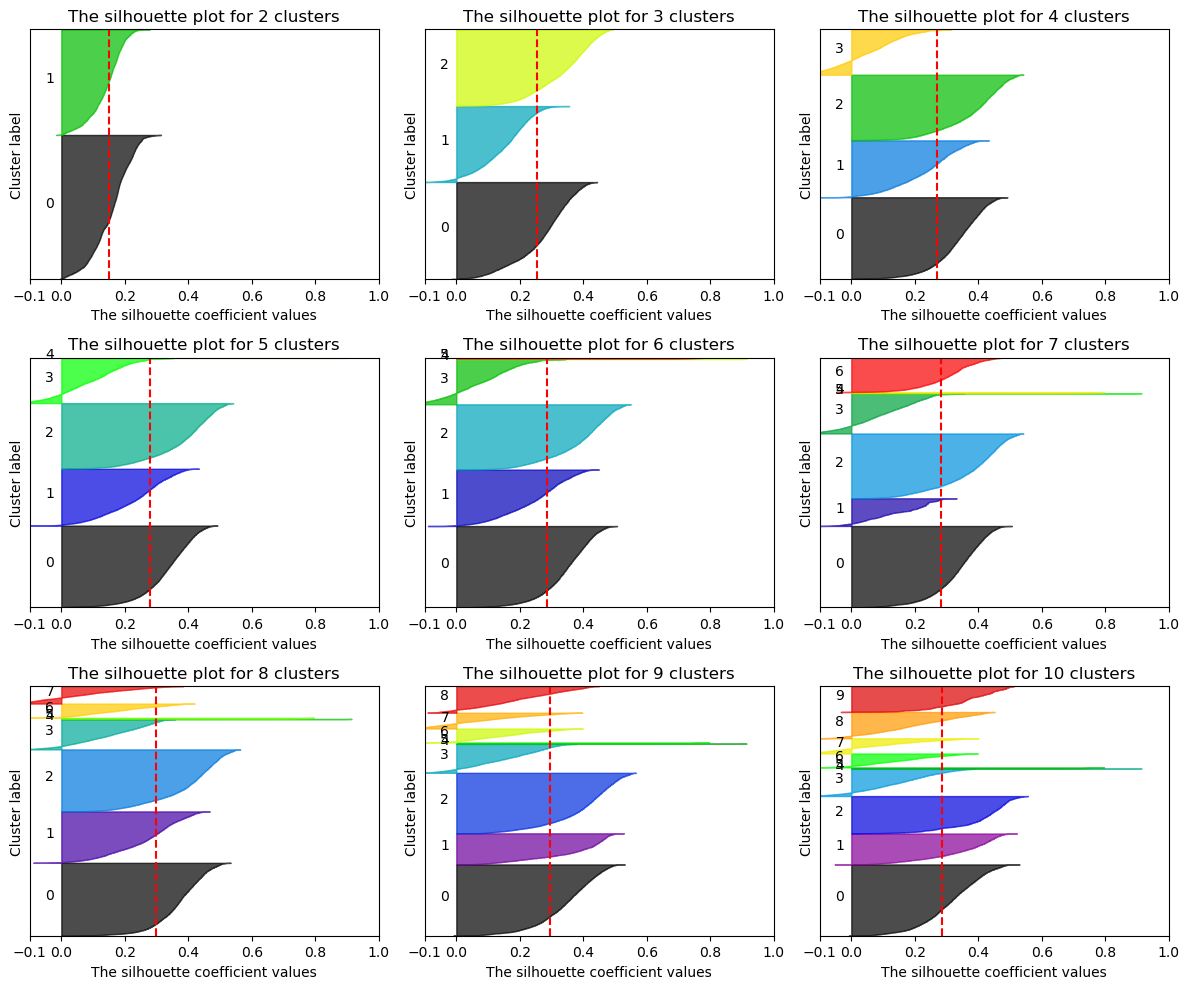

,num_of_clusters,SSE,silhouette_avg,num_of_samples,Max,Min,samples_per_cluster
0,2,568625.210891,0.150020,43877,25326,18551,"{0: 25326, 1: 18551}"
1,3,470147.122201,0.253855,43877,17047,13355,"{0: 17047, 1: 13355, 2: 13475}"
2,4,421416.486318,0.271256,43877,14381,7967,"{0: 14381, 1: 9992, 2: 11537, 3: 7967}"
3,5,348747.410240,0.278155,43877,14378,38,"{0: 14378, 1: 9991, 2: 11537, 3: 7933, 4: 38}"
4,6,268711.098734,0.286242,43877,14303,38,"{0: 14303, 1: 9925, 2: 11477, 3: 7945, 4: 38, ..."
5,7,253703.990315,0.283846,43877,14315,38,"{0: 14315, 1: 4867, 2: 11396, 3: 7033, 4: 38, ..."
6,8,226111.097838,0.299125,43877,12820,38,"{0: 12820, 1: 9043, 2: 10908, 3: 5306, 4: 38, ..."
7,9,208816.041365,0.295645,43877,12539,38,"{0: 12539, 1: 5472, 2: 10643, 3: 5087, 4: 38, ..."
8,10,194391.864571,0.284462,43877,12543,38,"{0: 12543, 1: 5438, 2: 6586, 3: 4792, 4: 38, 5..."


In [145]:
# Define the range of clusters you want to try
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create an empty DataFrame to store the results
res_df = pd.DataFrame(columns=['num_of_clusters', 'SSE', 'silhouette_avg', 'num_of_samples', 'Max', 'Min', 'samples_per_cluster'])

# Create a subplot with 2 rows and 2 columns
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for n_clusters, ax in zip(range_n_clusters, axes.flatten()):
    # The subplot is the silhouette plot
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 0 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto").fit(X_pca)
    cluster_labels = clusterer.labels_

    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    sse = clusterer.inertia_

    y_lower = 10
    cluster_samples = {}
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

        cluster_samples[i] = size_cluster_i

    ax.set_title(f"The silhouette plot for {n_clusters} clusters")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the y-axis labels/ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Collect results into the DataFrame
    sumple_count = np.bincount(cluster_labels)
    res_df = res_df.append({'num_of_clusters': n_clusters, 'SSE': sse, 'silhouette_avg': silhouette_avg,
                            'num_of_samples': sumple_count.sum(), 'Max': sumple_count.max(), 'Min': sumple_count.min(),
                            'samples_per_cluster': cluster_samples},
                           ignore_index=True)

plt.tight_layout()
plt.show()

res_df

**also according to the silhouette we can say that 7 clasters will be ideal.**


#### adding a column that will give the correct cluster for each event

In [146]:
cluster = KMeans(n_clusters=7, random_state=42, n_init="auto").fit(X_pca)

# Assuming df contains the data you want to cluster
clustered_data = df.copy()
clustered_data['Cluster'] = cluster.labels_

dfs = []  # List to store the DataFrames

for i in range(7):
    # Create a new DataFrame for each cluster
    new_df = clustered_data[clustered_data['Cluster'] == i].copy()
    dfs.append(new_df)


# Merge the DataFrames on the index
merged_df = pd.concat(dfs, axis=0)

# Display the final merged DataFrame
print("Merged DataFrame:")
merged_df

Merged DataFrame:


,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,latitude,longitude,...,contributing_factor_vehicle_2_View Obstructed/Limited,borough_BRONX,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,time_category_morning,time_category_night,time_category_noon,Cluster
2,1,0,0,0,0,0,1,0,40.631650,-74.087620,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,1,0,0,0,1,0,0,0,40.687534,-73.977500,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,1,0,0,0,0,0,1,0,40.710957,-73.951126,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
6,1,0,0,0,0,0,1,0,40.624170,-73.970480,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
7,1,0,0,0,0,0,1,0,40.692356,-73.942820,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43829,1,0,0,0,1,0,0,0,40.766610,-73.965000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,6
43858,1,0,0,0,0,0,1,0,40.817680,-73.929750,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6
43863,1,0,0,0,0,0,1,0,40.705030,-74.013336,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,6
43864,1,0,0,0,0,0,1,0,40.822315,-73.819180,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6


In [147]:
# merged_df1 = merged_df
# merged_df = merged_df1
merged_df['index_values'] = merged_df.index

# df_concatenated_dropped1 = df_concatenated_dropped
# df_concatenated_dropped = df_concatenated_dropped1
df_concatenated_dropped['index_values'] = df_concatenated_dropped.index

In [148]:
df_concatenated_dropped['location'] = list(zip(df_concatenated_dropped['latitude'], df_concatenated_dropped['longitude']))
# df_concatenated_dropped = df_concatenated_dropped.drop(['latitude', 'longitude'], axis=1)


In [149]:
merged_df = merged_df[['latitude', 'longitude', 'Cluster', 'index_values']]
merged_df['location'] = list(zip(merged_df['latitude'], merged_df['longitude']))
merged_df = merged_df.drop(['latitude', 'longitude'], axis=1)
# Assuming merged_df is your DataFrame
merged_df = pd.DataFrame({
    'index_values': merged_df['index_values'],
    'location': merged_df['location'],
    'Cluster': merged_df['Cluster']

})
merged_df

C:\Users\Selau\AppData\Local\Temp\ipykernel_31612\1424585751.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['location'] = list(zip(merged_df['latitude'], merged_df['longitude']))


,index_values,location,Cluster
2,2,"(40.63165, -74.08762)",0
3,3,"(40.687534, -73.9775)",0
4,4,"(40.710957, -73.951126)",0
6,6,"(40.62417, -73.97048)",0
7,7,"(40.692356, -73.94282)",0
...,...,...,...
43829,43829,"(40.76661, -73.965)",6
43858,43858,"(40.81768, -73.92975)",6
43863,43863,"(40.70503, -74.013336)",6
43864,43864,"(40.822315, -73.81918)",6


#### merging with the original file

In [150]:
# Assuming 'latitude' and 'longitude' are the common columns
result = pd.merge(df_concatenated_dropped,merged_df, on=['index_values'], how='left')


In [151]:
result.drop(['index_values', 'location_y'], axis=1)
result['crash_time'] = result['crash_time'].dt.strftime('%H:%M')

result

,crash_date,crash_time,on_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,...,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,time_category_morning,time_category_night,time_category_noon,index_values,location_x,location_y,Cluster
0,2021-12-14T00:00:00,23:10,NORTH CONDUIT AVENUE,2,0,0,0,0,0,2,...,0.0,1.0,0.0,0.0,1.0,0.0,0,"(40.66684, -73.78941)","(40.66684, -73.78941)",2
1,2021-12-11T00:00:00,19:43,WEST KINGSBRIDGE ROAD,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,1,"(40.87262, -73.904686)","(40.87262, -73.904686)",1
2,2021-12-13T00:00:00,17:40,VICTORY BOULEVARD,1,0,0,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,2,"(40.63165, -74.08762)","(40.63165, -74.08762)",0
3,2021-12-14T00:00:00,12:54,FULTON STREET,1,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,3,"(40.687534, -73.9775)","(40.687534, -73.9775)",0
4,2021-12-14T00:00:00,17:15,GRAND STREET,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,4,"(40.710957, -73.951126)","(40.710957, -73.951126)",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43872,2019-01-14T00:00:00,15:20,1 AVENUE,1,0,0,0,0,0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,43872,"(40.76649, -73.95696)","(40.76649, -73.95696)",1
43873,2019-02-02T00:00:00,12:00,COLLEGE POINT BOULEVARD,1,0,0,0,0,0,1,...,0.0,1.0,0.0,1.0,0.0,0.0,43873,"(40.746902, -73.834694)","(40.746902, -73.834694)",2
43874,2019-01-15T00:00:00,14:47,248 STREET,1,0,0,0,0,0,1,...,0.0,1.0,0.0,0.0,0.0,1.0,43874,"(40.740623, -73.72135)","(40.740623, -73.72135)",2
43875,2019-01-27T00:00:00,14:50,167 STREET,1,0,0,0,0,0,1,...,0.0,1.0,0.0,0.0,0.0,1.0,43875,"(40.69421, -73.78523)","(40.69421, -73.78523)",3


## **Result and Post-processing**

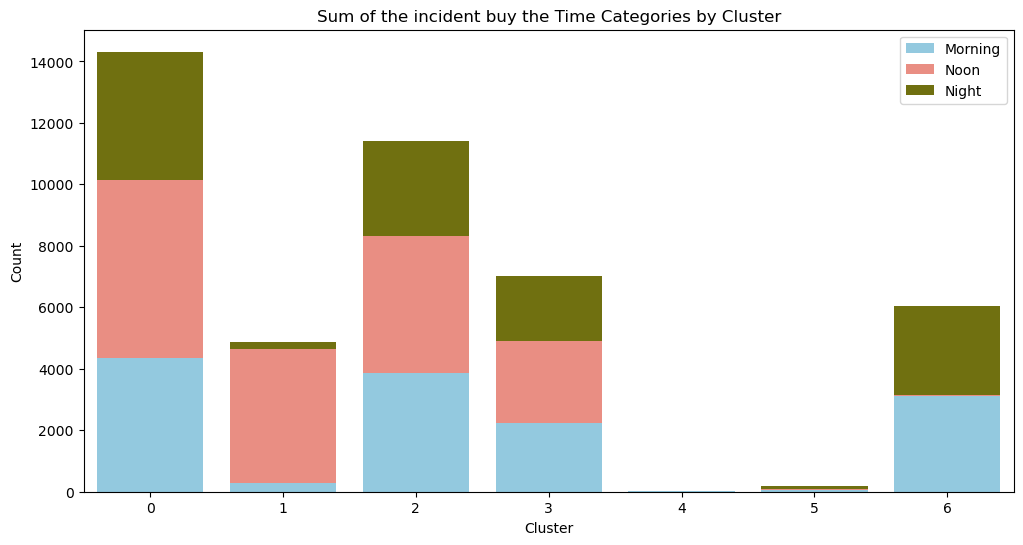

In [153]:
# Group by cluster and sum the binary values
time_category_sums = result.groupby('Cluster')[['time_category_morning', 'time_category_noon', 'time_category_night']].sum()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=time_category_sums, x=time_category_sums.index, y='time_category_morning', color='skyblue', label='Morning')
sns.barplot(data=time_category_sums, x=time_category_sums.index, y='time_category_noon', color='salmon', bottom=time_category_sums['time_category_morning'], label='Noon')
sns.barplot(data=time_category_sums, x=time_category_sums.index, y='time_category_night', color='olive', bottom=time_category_sums['time_category_morning'] + time_category_sums['time_category_noon'], label='Night')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Sum of the incident buy the Time Categories by Cluster')
plt.legend()
plt.show()


we can already see 4 main clusters

In [154]:
result.head()

,crash_date,crash_time,on_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,...,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,time_category_morning,time_category_night,time_category_noon,index_values,location_x,location_y,Cluster
0,2021-12-14T00:00:00,23:10,NORTH CONDUIT AVENUE,2,0,0,0,0,0,2,...,0.0,1.0,0.0,0.0,1.0,0.0,0,"(40.66684, -73.78941)","(40.66684, -73.78941)",2
1,2021-12-11T00:00:00,19:43,WEST KINGSBRIDGE ROAD,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,1,"(40.87262, -73.904686)","(40.87262, -73.904686)",1
2,2021-12-13T00:00:00,17:40,VICTORY BOULEVARD,1,0,0,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,2,"(40.63165, -74.08762)","(40.63165, -74.08762)",0
3,2021-12-14T00:00:00,12:54,FULTON STREET,1,0,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,3,"(40.687534, -73.9775)","(40.687534, -73.9775)",0
4,2021-12-14T00:00:00,17:15,GRAND STREET,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,4,"(40.710957, -73.951126)","(40.710957, -73.951126)",0


#### checking the distributions of the incidents between the clusters

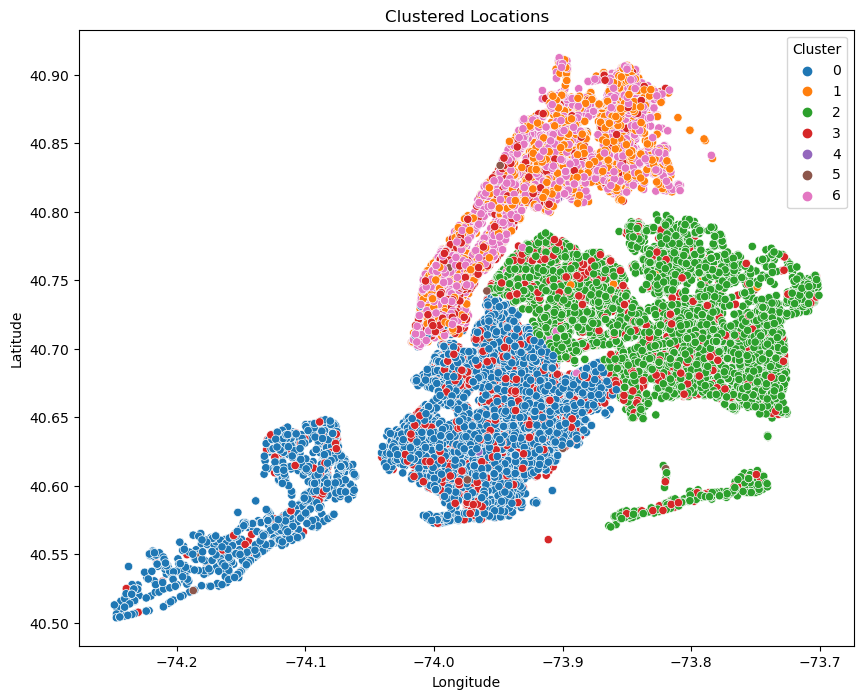

In [155]:
# Convert tuples to strings
result['location_x'] = result['location_x'].astype(str)

# Extract latitude and longitude
result['latitude'] = result['location_x'].apply(lambda x: x.split(',')[0].strip('('))
result['longitude'] = result['location_x'].apply(lambda x: x.split(',')[1].strip(')'))

# Convert latitude and longitude to float
result['latitude'] = result['latitude'].astype(float)
result['longitude'] = result['longitude'].astype(float)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', hue='Cluster', data=result, palette='tab10')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustered Locations')
plt.show()

** we can see that the main 4 clusters are 0,1,2,3 and 6 while the 0,2 and 6 are mainly clustered be the location while 3 is spread all over **

after checking most of the contribution factors, we can say that there is no signicant factor that is emphasize in a specific cluster

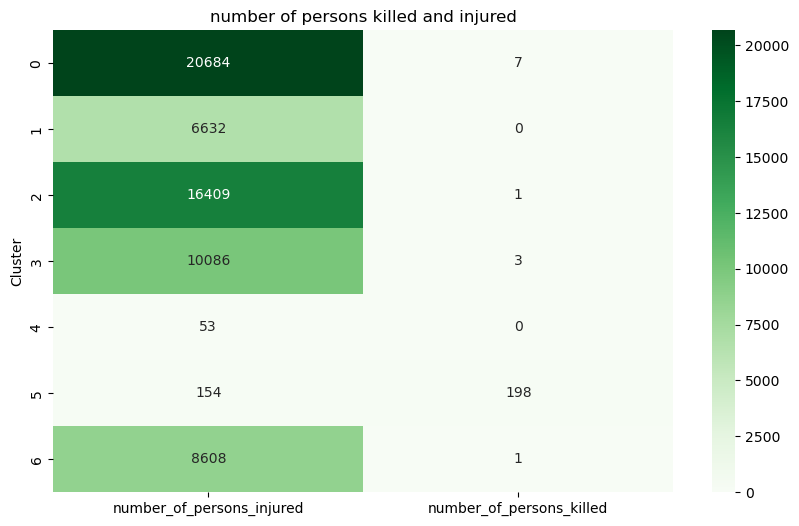

In [156]:
# Create a pivot table
pivot_table = result.pivot_table(index='Cluster', 
                                 values=['number_of_persons_killed', 'number_of_persons_injured'], 
                                 aggfunc='sum')

# Plotting with a light green colormap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='Greens', fmt='g')
plt.title('number of persons killed and injured')
plt.show()


we can see that cluster number 5 is very much clustered by the people got killed in the car incidents, while 0,1,2,3 and 6 are clustered by the people got injured.

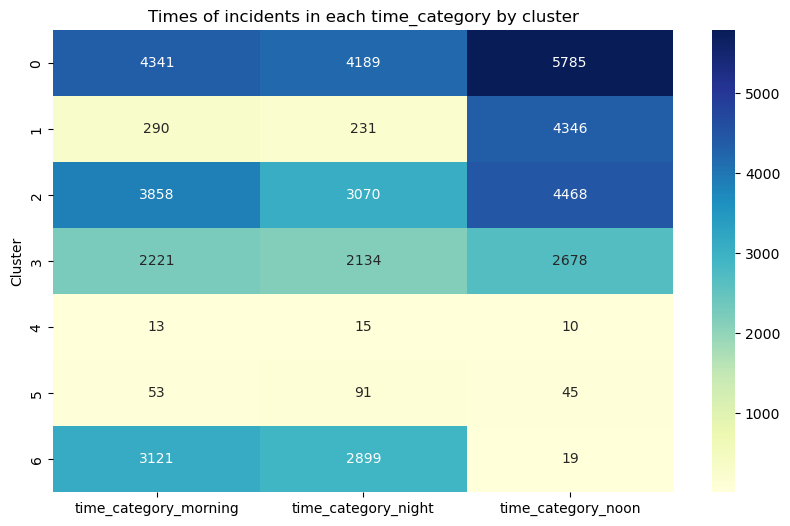

In [157]:
# Create a pivot table
pivot_table = result.pivot_table(index='Cluster', 
                                 values=['time_category_morning', 'time_category_noon', 'time_category_night'], 
                                 aggfunc='sum')

# Plotting with a light yellow colormap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Times of incidents in each time_category by cluster')
plt.show()

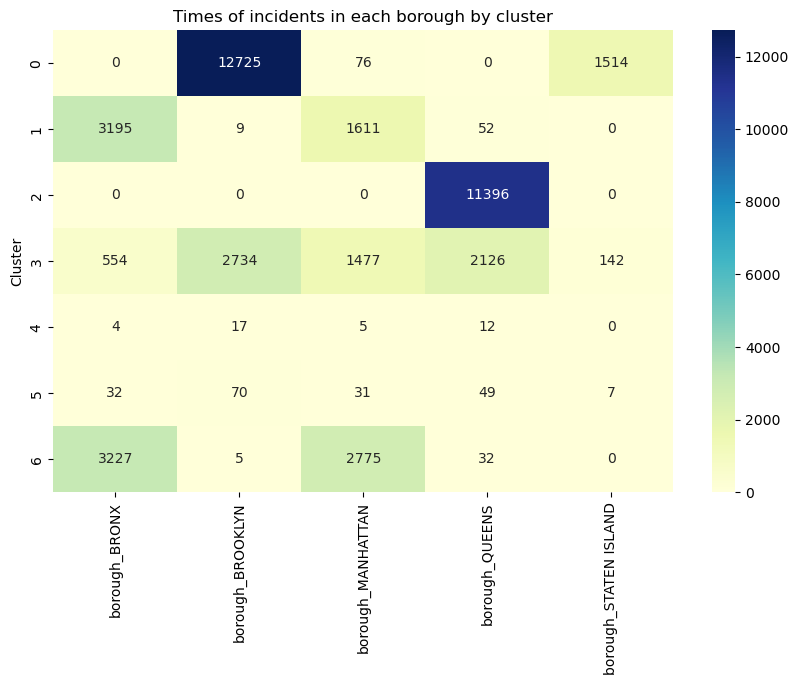

In [158]:
# Create a pivot table
pivot_table = result.pivot_table(index='Cluster', 
                                 values=['borough_BROOKLYN', 'borough_MANHATTAN', 'borough_QUEENS','borough_STATEN ISLAND','borough_BRONX'], 
                                 aggfunc='sum')

# Plotting with a light yellow colormap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Times of incidents in each borough by cluster')
plt.show()